### Score: 44

Q1.[4+4+4]

Q2.[10+7]

Q3.[5+10]

C:\Users\zjm\AppData\Local\Temp\ipykernel_9448\1638925528.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  xch4 = nc_file.variables["xch4"][:]
C:\Users\zjm\AppData\Local\Temp\ipykernel_9448\1638925528.py:40: RuntimeWarning: Mean of empty slice
  monthly_climatology = np.nanmean(xch4[:num_years * 12].reshape(-1, 12, *xch4.shape[1:]), axis=0)
C:\Users\zjm\AppData\Local\Temp\ipykernel_9448\1638925528.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


xch4 shape: (210, 36, 72)
missing_value: 1e+20
xch4 shape after transpose: (210, 36, 72)
Number of time steps: 210
monthly_climatology shape: (12, 36, 72)


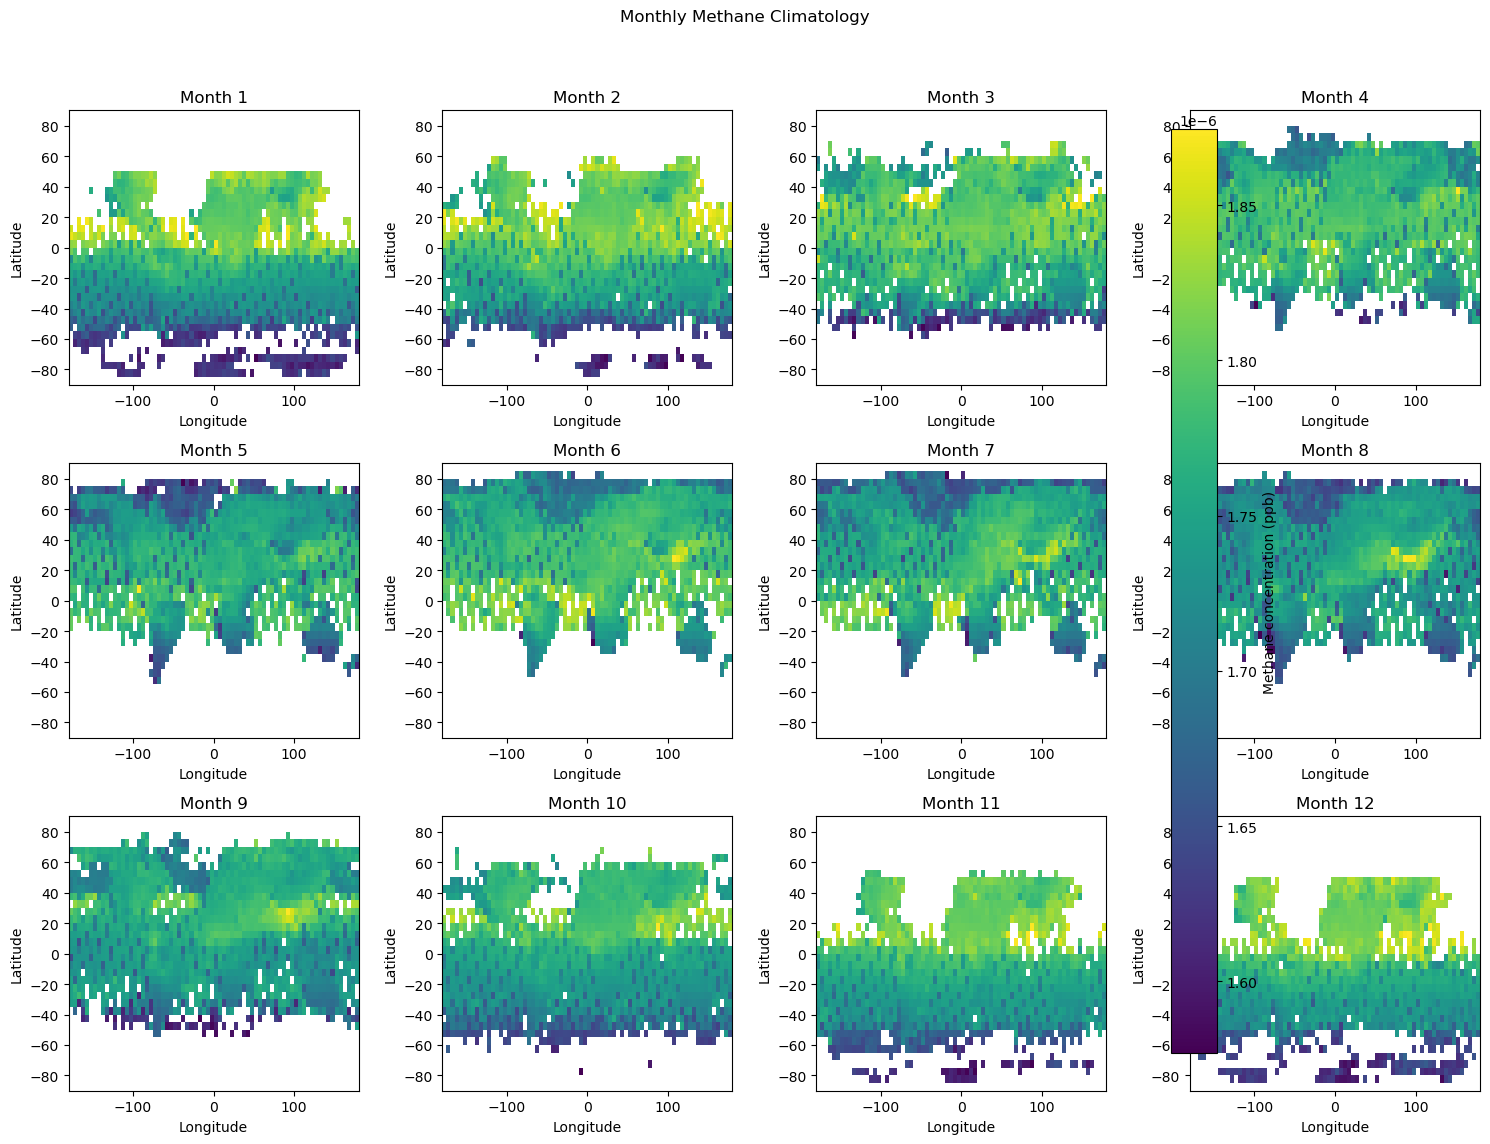

In [1]:
#1.1
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Load the netCDF file
file_path = r"C:\Users\zjm\Desktop\ESE_5023\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
nc_file = Dataset(file_path, mode="r")

# Extract variables
xch4 = nc_file.variables["xch4"][:]
lat = nc_file.variables["lat"][:]
lon = nc_file.variables["lon"][:]

# Check the shape of xch4
print(f"xch4 shape: {xch4.shape}")

# Check missing_value attribute and replace with NaN
missing_value = getattr(nc_file.variables['xch4'], 'missing_value', None)
if missing_value is not None:
    print(f"missing_value: {missing_value}")
    xch4 = np.where(xch4 == missing_value, np.nan, xch4)

# Ensure the data is in the shape (time, lat, lon)
if xch4.shape[0] == len(lat):  # If the first dimension matches the length of latitudes
    # The shape is likely (lat, lon, time)
    xch4 = np.transpose(xch4, (2, 0, 1))  # Transpose to (time, lat, lon)

# Check the shape again
print(f"xch4 shape after transpose: {xch4.shape}")

# Check the time dimension
num_times = xch4.shape[0]
print(f"Number of time steps: {num_times}")

# Compute methane climatology for each month
num_years = num_times // 12
if num_years < 1:
    raise ValueError("Not enough complete years in the dataset.")
monthly_climatology = np.nanmean(xch4[:num_years * 12].reshape(-1, 12, *xch4.shape[1:]), axis=0)

# Check the shape of monthly_climatology
print(f"monthly_climatology shape: {monthly_climatology.shape}")

# Plotting the results in 12 panels
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

for i in range(12):
    month_data = monthly_climatology[i]  # Select the correct month slice
    ax = axs.flat[i]
    im = ax.pcolormesh(lon, lat, month_data, shading="auto")
    ax.set_title(f"Month {i + 1}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Add color bar
# NOTE: 颜色条遮挡子图 -1
fig.colorbar(im, ax=axs.ravel().tolist(), label="Methane concentration (ppb)")

plt.suptitle("Monthly Methane Climatology")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\zjm\AppData\Local\Temp\ipykernel_9448\3278305255.py:4: RuntimeWarning: Mean of empty slice
  global_average = np.nanmean(xch4, axis=(1, 2))  # 对纬度和经度求平均


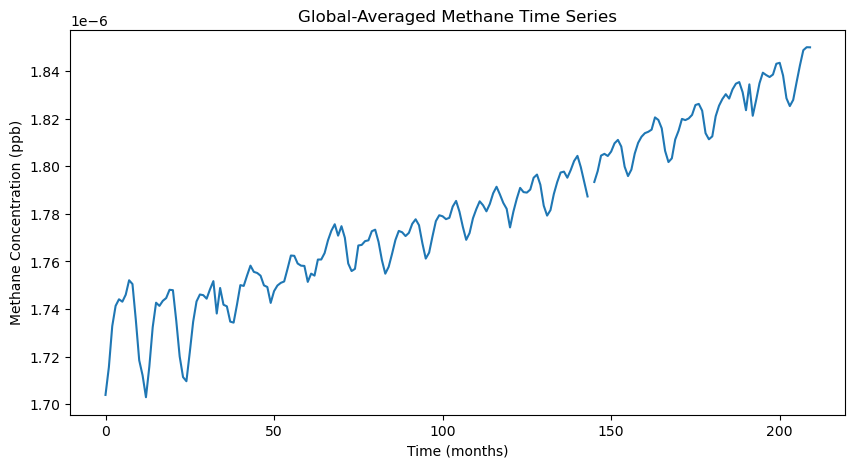

In [2]:
#1.2
# 计算全球平均甲烷并绘制时间序列图
# 使用 np.nanmean 处理 NaN 值
global_average = np.nanmean(xch4, axis=(1, 2))  # 对纬度和经度求平均
time_series = global_average.flatten()  # 将多维数组展平为一维数组

# 绘制时间序列图
plt.figure(figsize=(10, 5))
plt.plot(time_series)
plt.title('Global-Averaged Methane Time Series')
plt.xlabel('Time (months)')
# NOTE: 数据已经乘以了1e-6，因此此处量纲应为1 -1
plt.ylabel('Methane Concentration (ppb)')
plt.show()

point_time_series length: 210
Adjusted point_time_series length: 204


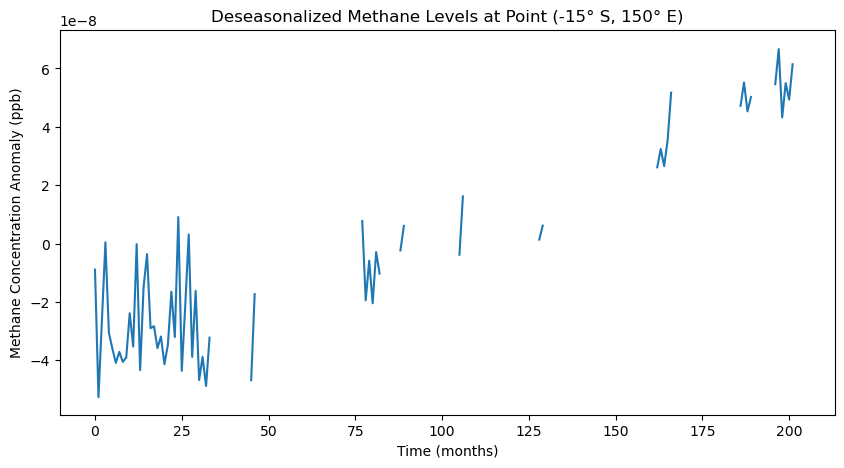

In [14]:
#1.3
# 计算去季节化甲烷水平并在指定点绘制时间序列图
point_lat = -15
point_lon = 150
# 找到最接近给定点的索引
lat_idx = (np.abs(lat - point_lat)).argmin()
lon_idx = (np.abs(lon - point_lon)).argmin()

# 提取该点的时间序列
point_time_series = xch4[:, lat_idx, lon_idx]

# 检查时间序列的长度
print(f"point_time_series length: {len(point_time_series)}")

# 处理数据长度不是 12 的倍数的情况
if len(point_time_series) % 12 != 0:
    # 截断或填充数据
    num_years = len(point_time_series) // 12
    point_time_series = point_time_series[:num_years * 12]
    print(f"Adjusted point_time_series length: {len(point_time_series)}")

# 去除季节性影响
# 这里我们简单地减去每个月的平均值作为去季节化的近似方法
# NOTE: 数据中存在空值，因此计算平均值的结果全为空 -1
# monthly_means = point_time_series.reshape(-1, 12).mean(axis=0)
monthly_means = point_time_series.reshape(-1, 12)
monthly_means = np.nanmean(monthly_means, axis=0)

deseasonalized_time_series = point_time_series - np.tile(monthly_means, len(point_time_series) // 12)

# 检查去季节化时间序列中是否存在全是 NaN 的值
if np.isnan(deseasonalized_time_series).all():
    print("Warning: All values in the deseasonalized time series are NaN.")
else:
    # 绘制时间序列图
    plt.figure(figsize=(10, 5))
    plt.plot(deseasonalized_time_series)
    plt.title('Deseasonalized Methane Levels at Point (-15° S, 150° E)')
    plt.xlabel('Time (months)')
    # NOTE: 问题同1.2
    plt.ylabel('Methane Concentration Anomaly (ppb)')
    plt.show()

Monthly climatology computed and saved.


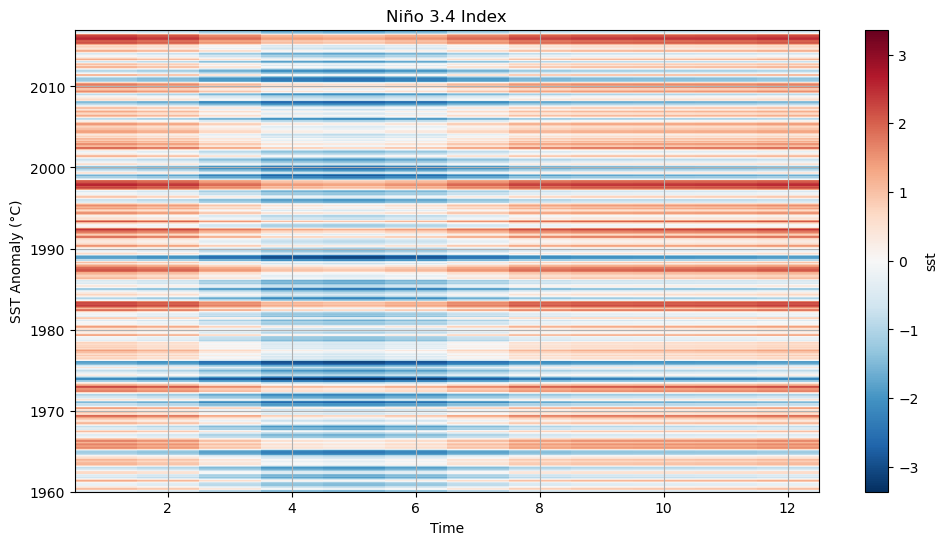

Visualization of Niño 3.4 index completed.


In [12]:
#2
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# 从本地读取数据
file_path = r'C:\Users\zjm\Desktop\ESE_5023\NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(file_path)

# 选择 Niño 3.4 区域
# 注意：ERSSST 数据的经度范围是从 0 到 360 度
# 170W 到 120W 对应的是 190 到 240
nino_region = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))

# 计算月气候学
monthly_climatology = nino_region.groupby('time.month').mean('time')

# 计算 SST 异常
sst_anomalies = nino_region.sst - monthly_climatology.sst

# 保存异常到 NetCDF 文件
sst_anomalies.to_netcdf("nino_34_sst_anomalies.nc")

print("Monthly climatology computed and saved.")

# 加载异常数据集
anomalies_ds = xr.open_dataset("nino_34_sst_anomalies.nc")

# 计算 Niño 3.4 指数
# NOTE: 没有计算滑动平均 -1
nino_34_index = anomalies_ds.sst.mean(dim=['lat', 'lon'])

# 可视化 Niño 3.4 指数
# NOTE: 此处的图应该参照2.2给出的例图进行绘制 -2
plt.figure(figsize=(12, 6))
nino_34_index.plot()
plt.title('Niño 3.4 Index')
plt.xlabel('Time')
plt.ylabel('SST Anomaly (°C)')
plt.grid(True)
plt.show()

print("Visualization of Niño 3.4 index completed.")


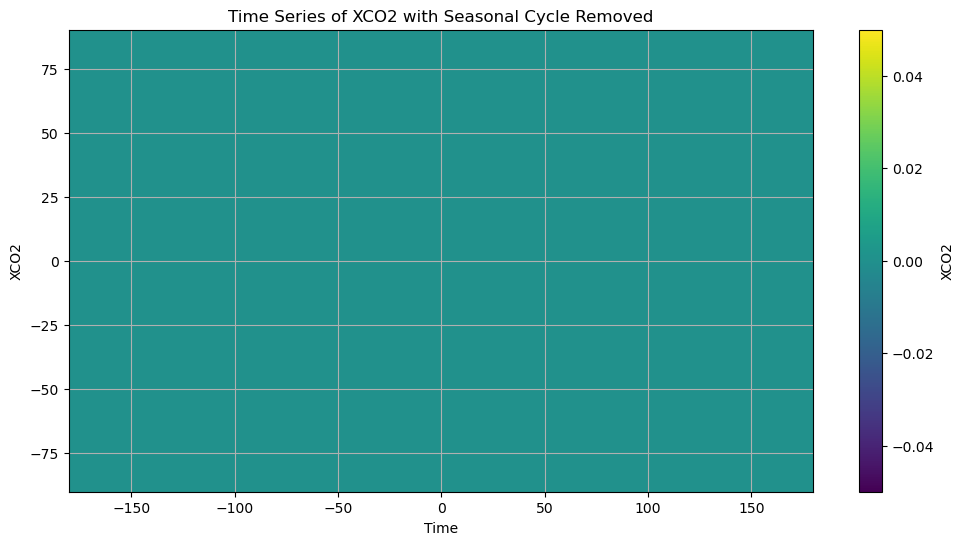

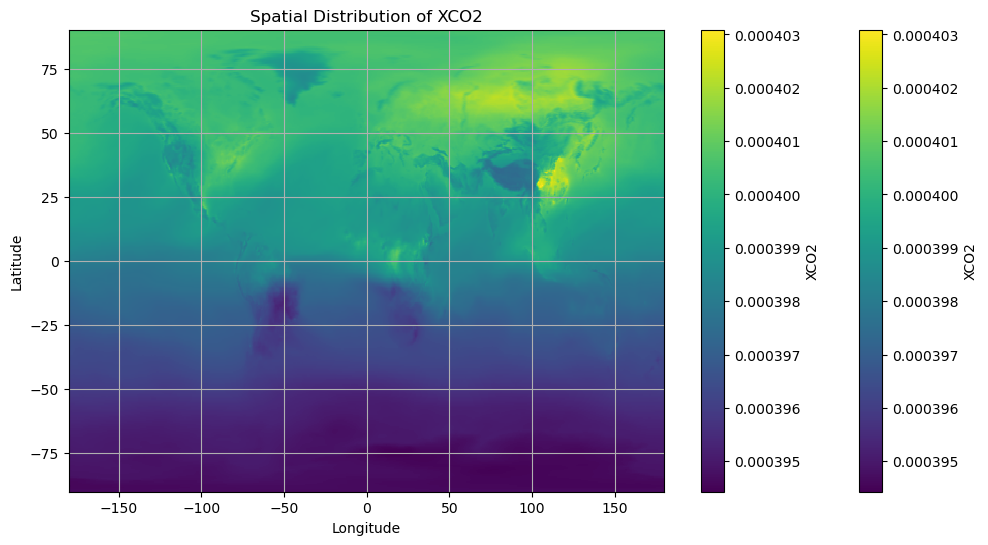

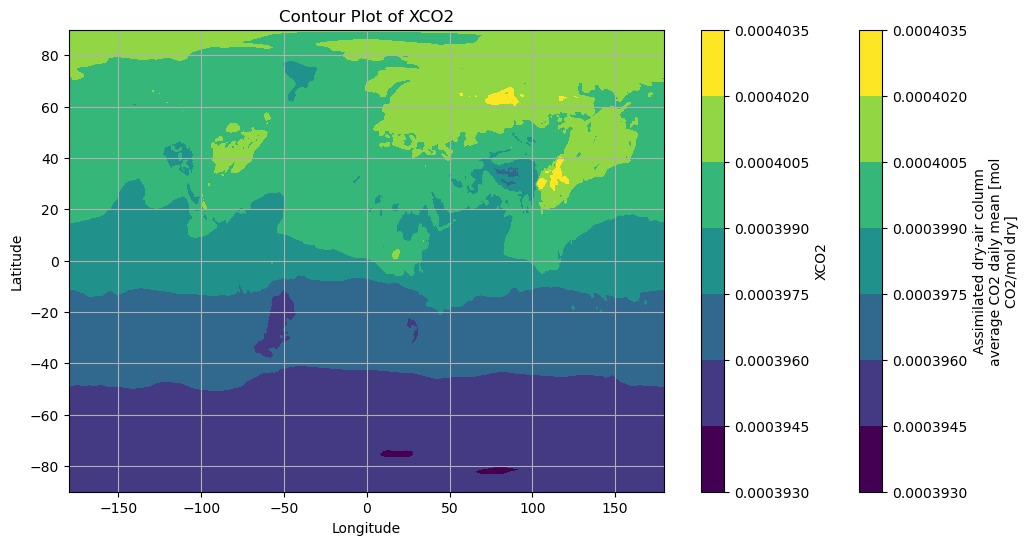

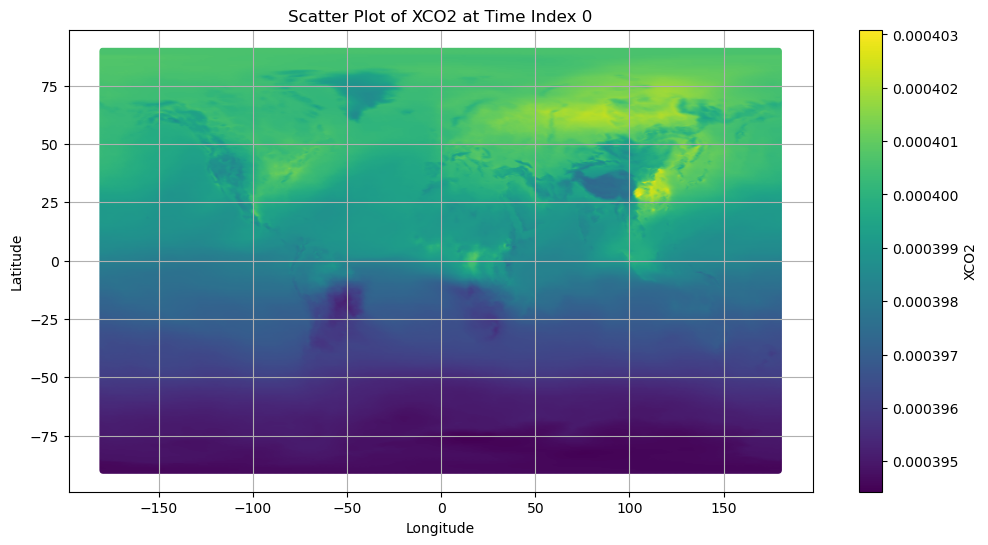

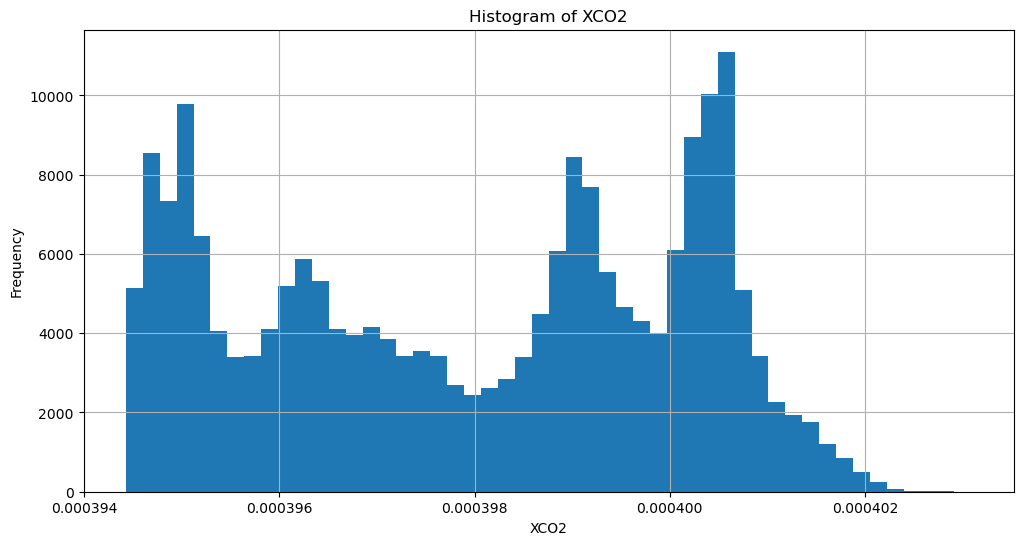

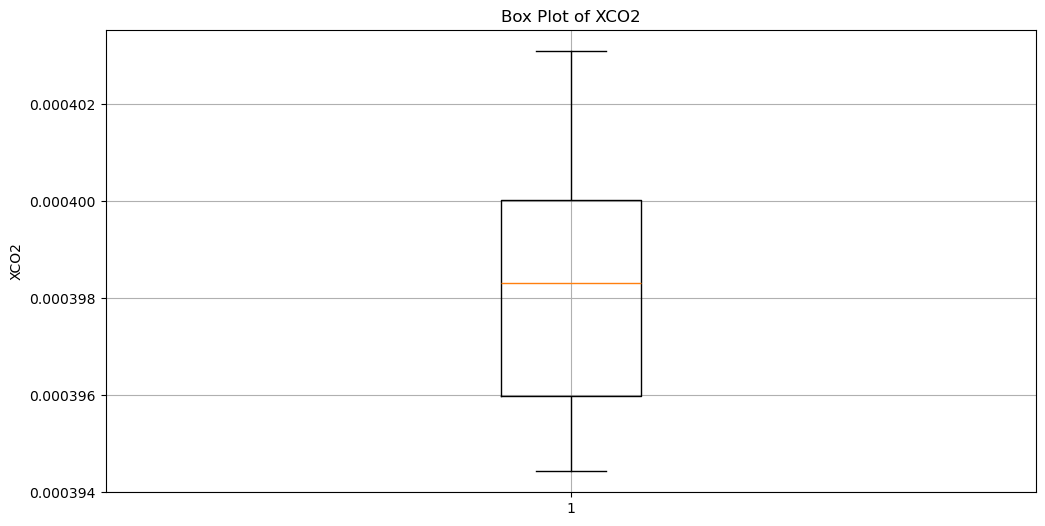

In [41]:
#3
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 定义文件路径
file_path = 'D:\\Work\\ESE5023\\oco2_GEOS_L3CO2_month_201501_B10206Ar.nc4'

# 读取数据
ds = xr.open_dataset(file_path)

# 选择感兴趣的变量
variable_name = 'XCO2'

# 提取变量数据
data = ds[variable_name]

# 计算月均值 (使用 'ME' 替代 'M')
monthly_mean = data.resample(time='ME').mean('time')

# 计算季节性循环
seasonal_cycle = monthly_mean.groupby('time.month').mean('time')

# 移除季节性循环
detrended_data = data.groupby('time.month') - seasonal_cycle

# 绘制时间序列图
plt.figure(figsize=(12, 6))
detrended_data.plot()
plt.title(f'Time Series of {variable_name} with Seasonal Cycle Removed')
plt.xlabel('Time')
plt.ylabel(variable_name)
plt.grid(True)
plt.show()

# 绘制空间分布图
plt.figure(figsize=(12, 6))
spatial_plot = data.mean(dim='time').plot(cmap='viridis')
plt.colorbar(spatial_plot, label=variable_name)
plt.title(f'Spatial Distribution of {variable_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# 绘制等值线图
plt.figure(figsize=(12, 6))
contourf_plot = data.isel(time=0).plot.contourf(cmap='viridis')
plt.colorbar(contourf_plot, label=variable_name)
plt.title(f'Contour Plot of {variable_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# 绘制散点图
time_index = 0  # 选择第一个时间点
lons = ds['lon'].values
lats = ds['lat'].values
values = data.isel(time=time_index).values.flatten()
lon_grid, lat_grid = np.meshgrid(lons, lats)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

plt.figure(figsize=(12, 6))
scatter_plot = plt.scatter(lon_flat, lat_flat, c=values, cmap='viridis', s=10)
plt.colorbar(scatter_plot, label=variable_name)
plt.title(f'Scatter Plot of {variable_name} at Time Index {time_index}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# 绘制直方图
plt.figure(figsize=(12, 6))
plt.hist(data.values.flatten(), bins=50)
plt.title(f'Histogram of {variable_name}')
plt.xlabel(variable_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 绘制箱形图
plt.figure(figsize=(12, 6))
plt.boxplot(data.values.flatten())
plt.title(f'Box Plot of {variable_name}')
plt.ylabel(variable_name)
plt.grid(True)
plt.show()